In [1]:
# 7.5

import numpy as np
import pandas as pd
from numpy.linalg import inv
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal, wishart

In [2]:
Y = pd.read_csv('pima.miss.csv', index_col=0)

In [3]:
# Prior Parameters

n, p = Y.shape
mu0 = np.array([120, 64, 26, 26])
sd0 = mu0 / 2
L0 = np.full(shape=(p, p), fill_value = 0.1)
np.fill_diagonal(L0, 1)
L0 = L0 * np.outer(sd0, sd0)
nu0 = p + 2
S0 = L0

In [4]:
# Starting Values
Sigma = S0
Y_full = np.array(Y)
O = 1 * (~Y.isna())

for j in range(p):
    # Replace missing values with column means
    Y_full[np.isnan(Y_full[:,j]),j] = np.mean(Y_full[~np.isnan(Y_full[:,j]),j])

In [5]:
# Gibbs Sampler
THETA = []
SIGMA = []
Y_MISS = []
samples = 1000

for s in range(samples):
    # Update Theta
    ybar = np.mean(Y_full, 0)
    Ln = inv(inv(L0) + n*inv(Sigma))
    mun = np.matmul(Ln, np.matmul(inv(L0), mu0) + n * np.matmul(inv(Sigma), ybar))
    theta = multivariate_normal(mean=mun, cov=Ln).rvs(1)
    
    # Update Sigma
    Sn = S0 + np.matmul((Y_full - theta).T, (Y_full - theta))
    Sigma = inv(wishart(nu0 + n, inv(Sn)).rvs(1))
    
    for i in range(n):
        b = (O.iloc[i,:] == 0)
        a = (O.iloc[i,:] == 1)
        iSa = inv(Sigma[a,:][:,a])
        beta_j = np.matmul(Sigma[b,:][:,a], iSa)
        Sigma_j = Sigma[b,:][:,b] - np.matmul(np.matmul(Sigma[b,:][:,a], iSa), Sigma[a,:][:,b])
        theta_j = theta[b] + np.matmul(beta_j, (Y_full[i, a] - theta[a]).T)
        if sum(b) > 0:
            Y_full[i, b] = multivariate_normal(mean=theta_j, cov=Sigma_j).rvs(1)
    
    # Save Results
    THETA.append(theta)
    SIGMA.append(Sigma)
    Y_MISS.append(Y_full[O==0])

In [6]:
COR = np.zeros(shape=(p, p, samples))
BETA = np.zeros(shape=(p, p-1, samples))

for s in range(samples):
    Sig = SIGMA[s]
    cor = Sig / np.sqrt(np.outer(np.diag(Sig), np.diag(Sig)))
    COR[:,:,s] = cor
    betas = []
    for i in range(4):
        sigba = np.delete(Sig[i,:], i, axis=0)
        sigaa = np.delete(np.delete(Sig, i, 1), i, 0)
        beta_p = np.matmul(sigba, inv(sigaa))
        BETA[i, :, s] = beta_p

In [7]:
cor_conf = np.nanquantile(a=COR, q=(0.025, 0.975), axis=2)

In [8]:
reg_coef = np.nanquantile(BETA, q=(0.025, 0.975), axis=2)

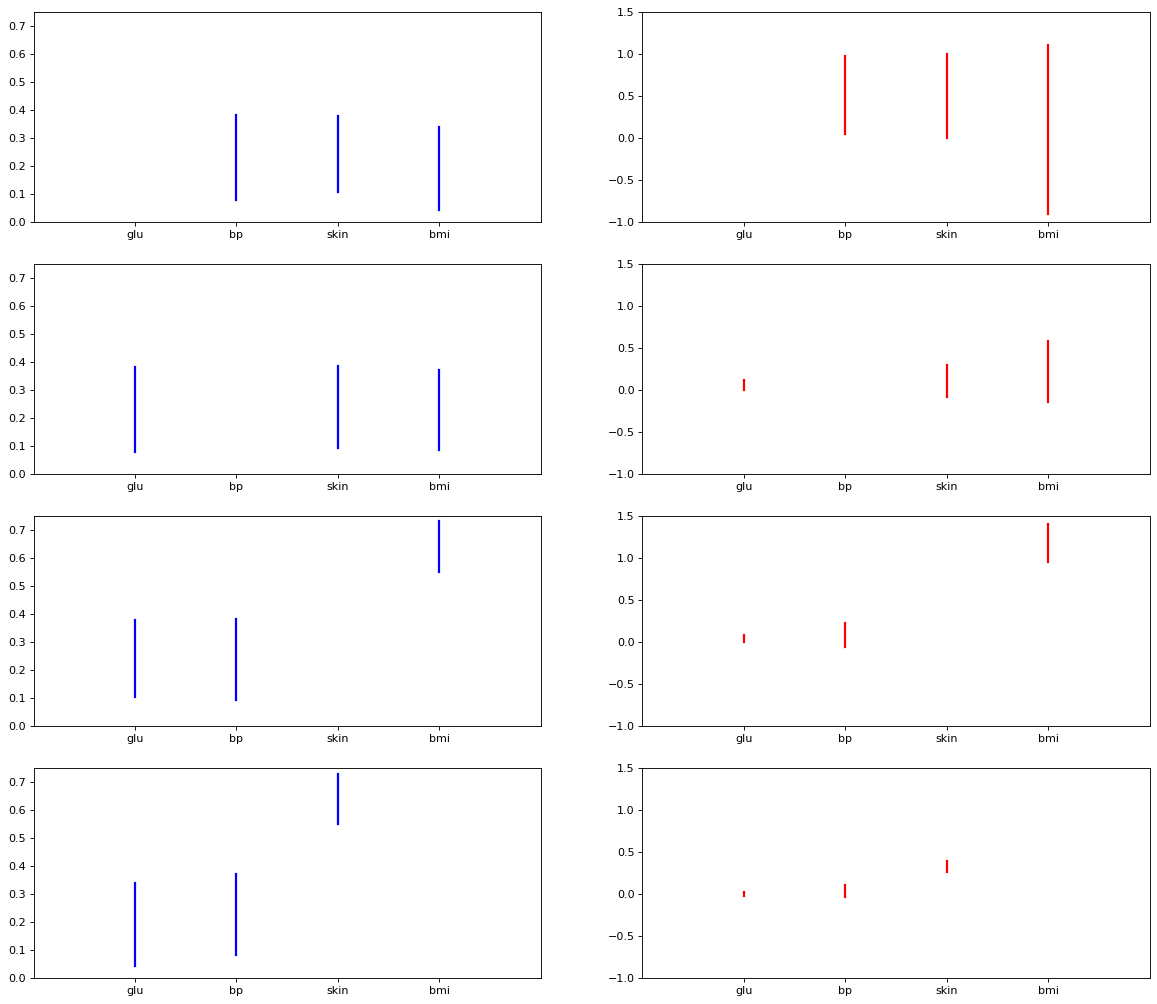

In [9]:
fig, axs = plt.subplots(4, 2, figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
pos = np.array([[a for a in range(0, 4)]]*2)

plt.setp(axs, xticks=np.arange(4), xticklabels=['glu', 'bp', 'skin', 'bmi'], xlim=(-1,4))
plt.setp(axs[:,0], ylim=(0, 0.75))
plt.setp(axs[:,1], ylim=(-1, 1.5))

# fig.suptitle('Vertically stacked subplots')
for i in range(4):
    X = np.delete(pos, i, 1)
    y =  np.delete(cor_conf[:,i], i, 1)
    axs[i, 0].plot(X, y, linewidth=2.0, color='b')
    
for i in range(4):
    X = np.delete(pos, i, 1)
    y = reg_coef[:,i,:]
    axs[i, 1].plot(X, y, linewidth=2.0, color='r')

In [10]:
Y_nomiss = pd.read_csv('pima_nomiss.csv', index_col=0)

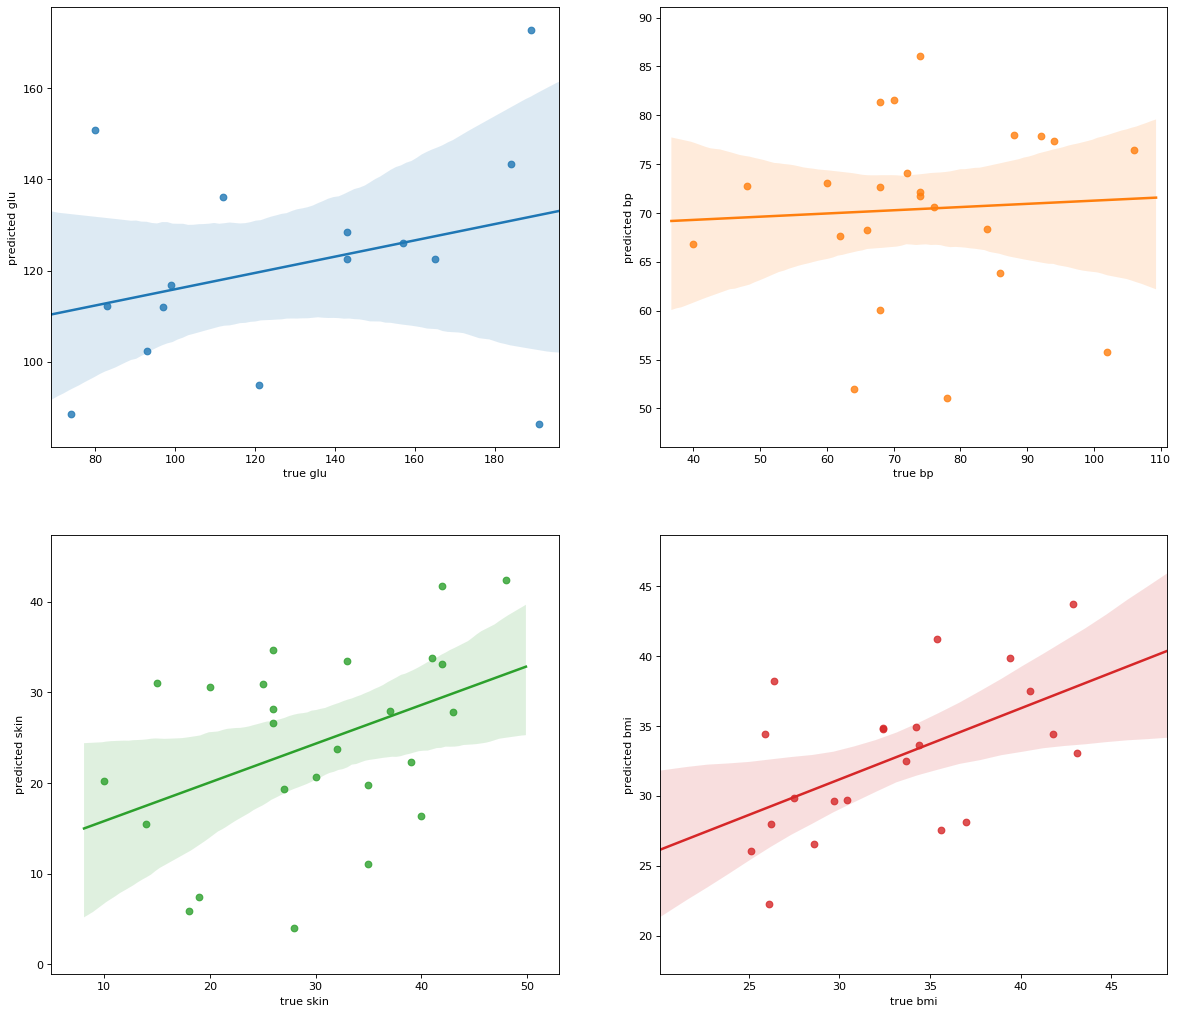

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
axind = [(0, 0), (0, 1), (1, 0), (1,1)]

for i in range(4):
    pred_y = Y_full[(O.iloc[:,i] == 0), i]
    true_y = np.array(Y_nomiss)[(O.iloc[:,i] == 0), i]
    sns.regplot(true_y, pred_y, ax=axs[axind[i]])
    axs[axind[i]].set(xlabel='true '+Y_nomiss.columns[i], 
                      ylabel='predicted '+ Y_nomiss.columns[i],
                      xlim = (min(true_y)-5, max(true_y)+5),
                      ylim = (min(pred_y)-5, max(pred_y)+5) )